In [1]:
# use if autocompletion is not working
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from os import getcwd, path
from tqdm.autonotebook import tqdm
from typing import List

#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Gensim
import gensim
import gensim.corpora as corpora

import spacy

# plotting
from matplotlib import pyplot as plt

<ipython-input-3-4621a4fb39e0>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from modern_slavery_registry.utils import dump_pickle

In [44]:
RANDOM_STATE = 40
PROJECT_PATH = getcwd().replace(
    path.basename(getcwd()), "")
MODEL_SAVE_PATH = path.join(PROJECT_PATH, "models")
PICKLE_PATH = path.join(PROJECT_PATH, "data\\pickles")

# Gensim LDA model on Bigrams (Using Gensim Phrases)

## Loading pre-processed dataset

In [6]:
PROJECT_PATH = getcwd()
PROJECT_PATH = PROJECT_PATH.replace("\\notebooks", "")
DATA_PATH = PROJECT_PATH + "\\data"
SHEETS_PATH = DATA_PATH + "\\sheets"

In [7]:
data = pd.read_excel(f"{SHEETS_PATH}\\subset_data.xlsx")
data.fillna("#NA", inplace=True)
data = data[["URL", "final_statement_cleaned"]]
n_sentences = len(data)
print(f"Found {n_sentences} non-NA statements")

Found 10078 non-NA statements


In [8]:
# to perform lemmatization
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(
    statements: List[str],
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) -> List[List[str]]:
    """https://spacy.io/api/annotation"""
    lemmatized_statements = []
    for statement in tqdm(statements):
        statement = nlp(statement) 
        lemmatized_statements.append(
            [token.lemma_ for token in statement if token.pos_ in allowed_postags])
    return lemmatized_statements

In [10]:
# to remove extra whitespaces
statements = [" ".join(statement.split()) for statement in tqdm(data["final_statement_cleaned"].values)]

  0%|          | 0/10078 [00:00<?, ?it/s]

In [11]:
# lemmatizing words in statements
statements = lemmatization(statements, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

  0%|          | 0/10078 [00:00<?, ?it/s]

In [12]:
# removing most repeated common words in statements
words_to_remove = ["modern", "slavery", "statement", "act", "supply", "human", "traffic"]
final_statements = []
for statement in tqdm(statements):
    final_statements.append([word for word in statement if word not in words_to_remove])

  0%|          | 0/10078 [00:00<?, ?it/s]

In [13]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(final_statements, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[final_statements], threshold=100)

In [14]:
def make_bigrams(corpus: List[List[str]])->List[List[str]]:
    return [bigram[words] for words in tqdm(corpus)]

def make_trigrams(corpus: List[List[str]])->List[List[str]]:
    return [trigram[bigram[words]] for words in tqdm(corpus)]

In [15]:
# preparing corpus to feed LDA model
statements_bigrams = make_bigrams(final_statements)

idx2word = corpora.Dictionary(statements_bigrams)
corpus = [
    idx2word.doc2bow(ngrams) for ngrams in tqdm(statements_bigrams)]

  0%|          | 0/10078 [00:00<?, ?it/s]

  0%|          | 0/10078 [00:00<?, ?it/s]

In [16]:
N_TOPICS = (2, 201)
LDA_MODELS = {}

In [17]:
for n in tqdm(range(*N_TOPICS)):
    LDA_MODELS[n] = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    num_topics=n,
    id2word=idx2word, 
    passes=1,
    iterations=50,
    random_state=RANDOM_STATE)
    dump_pickle(
        obj=LDA_MODELS[n], filename=f"bigrams_lda_model_{n}_topics", path=MODEL_SAVE_PATH)

  0%|          | 0/199 [00:00<?, ?it/s]

## Computing log perpexity w.r.t. to number of topics

In [19]:
LOG_PERPLEXITIES = {}
for n in tqdm(range(*N_TOPICS)):
    if n not in LOG_PERPLEXITIES.keys():
        LOG_PERPLEXITIES[n] = LDA_MODELS[n].log_perplexity(corpus)

  0%|          | 0/199 [00:00<?, ?it/s]

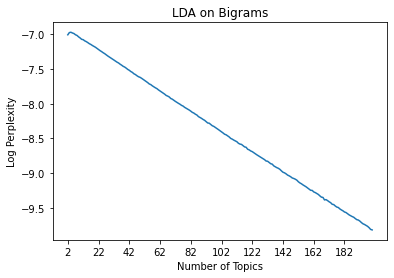

In [28]:
plt.plot(list(LOG_PERPLEXITIES.keys()), list(LOG_PERPLEXITIES.values()))
plt.xticks(range(*N_TOPICS, 20))
plt.xlabel("Number of Topics")
plt.ylabel("Log Perplexity")
plt.title("LDA on Bigrams")
plt.show()

In [29]:
def print_topic_keywords(lda_model):
    for topic in lda_model.print_topics():
        print(f"{topic[0]}: {topic[1:]}")
        print()

In [48]:
print_topic_keywords(LDA_MODELS[50])

42: ('0.047*"group" + 0.038*"risk" + 0.023*"supplier" + 0.022*"chain" + 0.019*"policy" + 0.016*"business" + 0.016*"procurement" + 0.013*"service" + 0.012*"year" + 0.011*"include"',)

37: ('0.026*"procurement" + 0.020*"supplier" + 0.016*"policy" + 0.015*"staff" + 0.015*"work" + 0.012*"process" + 0.011*"ensure" + 0.011*"chain" + 0.011*"include" + 0.010*"train"',)

44: ('0.029*"information" + 0.029*"datum" + 0.028*"process" + 0.023*"personal" + 0.016*"supplier" + 0.016*"provide" + 0.012*"service" + 0.010*"use" + 0.010*"request" + 0.009*"may"',)

1: ('0.004*"supplier" + 0.003*"risk" + 0.003*"right" + 0.003*"business" + 0.003*"include" + 0.002*"policy" + 0.002*"company" + 0.002*"chain" + 0.002*"labor" + 0.002*"conduct"',)

11: ('0.020*"chef" + 0.013*"pickup" + 0.008*"gluten_free" + 0.006*"bakery" + 0.006*"bread" + 0.004*"risk" + 0.003*"ship" + 0.003*"policy" + 0.003*"order" + 0.003*"chain"',)

45: ('0.057*"policy" + 0.020*"business" + 0.017*"may" + 0.016*"supplier" + 0.016*"ensure" + 0.016*

In [47]:
dump_pickle(
    LOG_PERPLEXITIES, 
    filename=f"bigrams_lda_model_log_perplexities_{N_TOPICS[0]}_{N_TOPICS[1]}_topics", 
    path=PICKLE_PATH)

In [46]:
dump_pickle(corpus, filename=f"bigrams_corpus_for_lda_model", path=PICKLE_PATH)
dump_pickle(idx2word, filename=f"bigrams_idx2word_for_lda_model", path=PICKLE_PATH)